# Simulating LiteBIRD-like TOD with beamconv

This demo shows the functionalities of a simple simulation pipeline. The code, based on beamconv and DUCC, returns noisy TOD given an input map, LiteBIRD's scanning strategy, the focal plane specifics and the noise power spectrum. Any feedback is much appreciated!

### Preliminary steps
First, we import all the modules and libraries that we need. In particular:
- <b>beamconv</b> (<a href="https://github.com/AdriJD/beamconv">github.com/AdriJD/beamconv</a>) simulates the scanning of the CMB sky while incorporating realistic beams and scan strategies. This code uses (spin-)spherical harmonic representations of the (polarized) beam response and sky to generate simulated CMB detector signal timelines. Beams can be arbitrarily shaped. Optionally, the results can be binned on the sphere. The code makes use of qpoint, a lightweight quaternion-based library for telescope pointing (<a href="https://github.com/arahlin/qpoint">github.com/arahlin/qpoint</a>).
- <b>DUCC</b> (<a href="https://gitlab.mpcdf.mpg.de/mtr/ducc">gitlab.mpcdf.mpg.de/mtr/ducc</a>) is a collection of basic programming tools for numerical computation, including Fast Fourier Transforms, Spherical Harmonic Transforms, non-equispaced Fourier transforms, as well as some concrete applications like 4pi convolution on the sphere and gridding/degridding of radio interferometry data.

We also used <b>PySM</b> (<a href="https://arxiv.org/abs/1608.02841">arxiv.org/abs/1608.02841</a>) to simulate maps of galactic emission in intensity and polarization at microwave frequencies: synchrotron, thermal dust, free-free, and anomalous microwave emission over the whole sky, in addition to the CMB signal. The scanning strategy was simulated by mimicking the functionality of <b>pyScan</b> (<a href="https://github.com/tmatsumu/LB_SYSPL_v4.2/tree/master/pyScans">github.com/tmatsumu/LB_SYSPL_v4.2/tree/master/pyScans</a>). Additionally, we made use of the LiteBIRD <b>IMO</b> database, from which we read the noise's and focal plane's specifics. 
The HWP specifics, were instead provided us by <b>Giampaolo</b> (thanks again!) as frequency-dependent Jones matrix elements.
The dipole was added making use (of a slightly modified version) of the <b>dipole module</b> in <code>litebird_sim</code>.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

# BEAMCONV
from beamconv import ScanStrategy

# DUCC
import ducc0

# PYSM
import pysm3
import pysm3.units as u

# LiteBIRD's IMO
import json
# opening IMO schema.json file and interpreting it as a dictionary
f = open('/afs/mpa/temp/monelli/litebird/litebird_imo-master/IMO/schema.json',)
data = json.load(f)  

# plot-related stuff
import copy
cmap_lighter = copy.copy(matplotlib.cm.get_cmap("YlOrBr_r"))
cmap_viridis = copy.copy(matplotlib.cm.get_cmap("viridis"))
cmap_magma = copy.copy(matplotlib.cm.get_cmap("magma"))

import warnings
warnings.filterwarnings("ignore")

import cycler

### Input maps

We need the input maps, consisting of CMB signal and foregrounds. I obtained them by making use of <b>PySM 3</b>. The components simulated are: thermal dust, synchrotron, AME, free-free, and CMB.

In [2]:
%%capture
sky = pysm3.Sky(nside=128, preset_strings=["a1", "d1", "f1", "s1", "c1"], output_unit="uK_CMB")

Given the emission <code>sky</code>, the map for a given frequence (140 GHz) can be extracted:

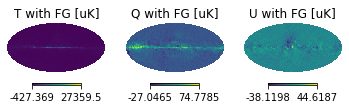

In [3]:
nu = 140 # since I'll be using the M1-140 channel
lmax = 256
map_FG = sky.get_emission(nu * u.GHz)
alm_FG = hp.map2alm(map_FG, lmax=lmax)

# plotting input maps
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
plt.axes(ax1)
hp.mollview(map_FG[0],title='T with FG [uK]', hold=True, cmap=cmap_viridis)
plt.axes(ax2)
hp.mollview(map_FG[1],title='Q with FG [uK]', hold=True, cmap=cmap_viridis)
plt.axes(ax3)
hp.mollview(map_FG[2],title='U with FG [uK]', hold=True, cmap=cmap_viridis)
plt.show()

Together with the <b>input maps</b>, we need to specify the <b>scanning strategy</b>, the <b>beam specifics</b> and the <b>focal plane specifics</b>. Provided with that, beamconv is able to produce the TOD. 

### Scanning strategy
Here I define two <code>ScanStrategy</code> objects: one with and one without HWP non-idealities.

In [4]:
sampling_freq = 19.0

# setting up the scanning strategy parameters
ctime0 = 1510000000            # initial time
mlen = 1 * 24 * 60 * 60        # mission length in seconds (one day!)

# definition of the scanning strategy making use of LiteBIRD's specifics (with ideal HWP)
ss = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun = 45.,          # [deg]
        theta_boresight = 50.,        # [deg]
        freq_antisun = 192.348,       # [min]
        freq_boresight = 0.314,       # [rad/min]
        sample_rate = sampling_freq,  # [Hz]
        jitter_amp=0.0,
        ctime0=ctime0)

# Definition of the scanning strategy making use of LiteBIRD's specifics (with HWP non-idealities)
ss_nonidealities = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun=45.,      # [deg]
        theta_boresight = 50.,  # [deg]
        freq_antisun = 192.348, # [min]
        freq_boresight = 0.314, # [rad/min]
        sample_rate = sampling_freq,     # [Hz]
        jitter_amp=0.0,
        ctime0=ctime0)

#### To do:
- Read the scanning strategy parameters from the IMO.

In order to generate a LiteBIRD-like scanning strategy, some functionalities of <b>pyScan</b> (<a href="https://github.com/tmatsumu/LB_SYSPL_updated">github.com/tmatsumu/LB_SYSPL_updated</a>) have been implemented in beamconv. In particular
- The <code>litebird_scan</code> function returns a quaternion that describes the boresight orientation (\theta, \phi and \psi angles) at any time sample;
- <code>litebird_ctime</code>, instead, produces unix time (<code>ctime</code>) for a given chunk.

In [5]:
# Further options (ideal HWP)
scan_opts = dict(
        q_bore_func=ss.litebird_scan,
        ctime_func=ss.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=2,
        nside_spin=128,
        preview_pointing=False,
        verbose=True,
        save_tod=True,
        save_point=True)

# Further options (non-ideal HWP)
scan_opts_nonidealities = dict(
        q_bore_func=ss_nonidealities.litebird_scan,
        ctime_func=ss_nonidealities.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=2,
        nside_spin=128,
        preview_pointing=False,
        verbose=True,
        save_tod=True,
        save_point=True)

Last thing to set up is the partition of the mission in chunks.

In [6]:
nchunk = 10

# calculate TOD in 10 chunks
nsamp_chunk = int(ss.mlen * ss.fsamp / nchunk)
nsamp = int(ss.mlen * ss.fsamp)
chunks = ss.partition_mission(nsamp_chunk)

# calculate TOD in 10 chunks
nsamp_chunk = int(ss_nonidealities.mlen * ss_nonidealities.fsamp / nchunk)
nsamp = int(ss_nonidealities.mlen * ss_nonidealities.fsamp)
chunks_nonidealities = ss_nonidealities.partition_mission(nsamp_chunk)

### HWP specifics
So far the two <code>ScanStrategy</code> objects (with and without non-idealities) are exactly identical. We can specify the HWP features when defining the beam and creating the focal plane. In particular, the HWP frequency can be specified with <code>set_hwp_mode</code>, while the Mueller matrix can be set up in in beam options. Giampaolo provided us the frequency-dependent elements of the HWP's Jones matrix and we tranformed it in frequency-dependent Mueller matrix elements, which we then fed to bemconv.

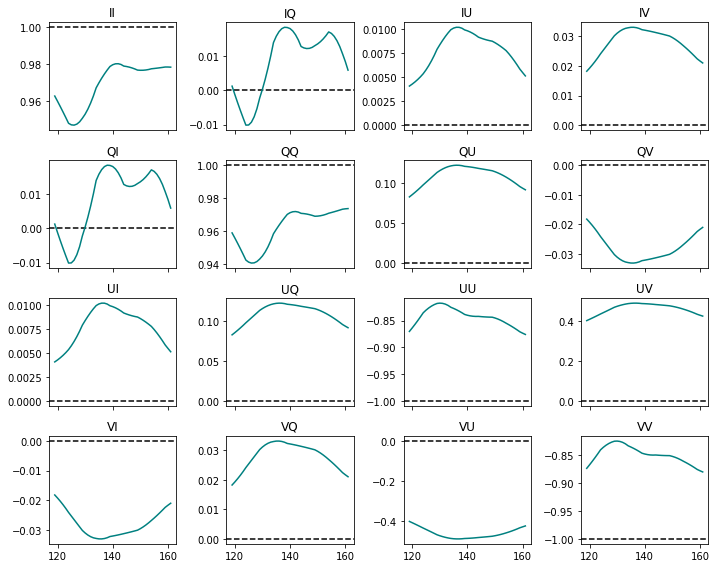

In [7]:
bandcenter = 140.0
bandwidth = 42.0

trans_rec = np.genfromtxt('MFT_HWP.csv', delimiter=';')

####################################################################
# Alex's definitions!

jones = np.zeros((trans_rec.shape[0],2,2), dtype='complex128')

jones[:,0,0] = trans_rec[:,1]**0.5
jones[:,0,1] = 10**(trans_rec[:,6]/10.)
jones[:,1,0] = 10**(trans_rec[:,6]/10.)
jones[:,1,1] = -trans_rec[:,3]**0.5*np.exp(1j*np.radians(trans_rec[:,5]-180))

####################################################################
# From Jones to Mueller matrix elements

###From Tom Hileman's transfer_matrix.py
Sigma = [] # Pauli + Indentity
Sigma.append( np.array(( (1,0),(0,1)), dtype=complex)) # identity matrix
Sigma.append( np.array(( (1,0),(0,-1)), dtype=complex))
Sigma.append( np.array(( (0,1),(1,0)), dtype=complex))
Sigma.append( np.array(( (0,-1j),(1j,0)), dtype=complex)) # Need to multiply by -1 to change back to normal.

mueller = np.zeros((trans_rec.shape[0],4,4))

# is this the correct definition?
freqs_array = np.concatenate(np.where(np.logical_and(trans_rec[:,0]>=bandcenter-bandwidth/2, trans_rec[:,0]<=bandcenter+bandwidth/2)))
    
for i in freqs_array:
    for j in range(4):
        for k in range(4):
            temp = .5*np.trace( np.dot(Sigma[j], np.dot(jones[i], np.dot(Sigma[k], jones[i].conj().transpose()))))
            mueller[i,j,k] = np.real(temp)

#Plot Mueller
fig, ax = plt.subplots(4,4, sharex=True, figsize=(10,8))
stokes_string = ["I","Q","U","V"]

ax[0,0].axhline(y=1,color='k',linestyle='dashed')
ax[0,1].axhline(y=0,color='k',linestyle='dashed')
ax[0,2].axhline(y=0,color='k',linestyle='dashed')
ax[0,3].axhline(y=0,color='k',linestyle='dashed')
ax[1,0].axhline(y=0,color='k',linestyle='dashed')
ax[1,1].axhline(y=1,color='k',linestyle='dashed')
ax[1,2].axhline(y=0,color='k',linestyle='dashed')
ax[1,3].axhline(y=0,color='k',linestyle='dashed')
ax[2,0].axhline(y=0,color='k',linestyle='dashed')
ax[2,1].axhline(y=0,color='k',linestyle='dashed')
ax[2,2].axhline(y=-1,color='k',linestyle='dashed')
ax[2,3].axhline(y=0,color='k',linestyle='dashed')
ax[3,0].axhline(y=0,color='k',linestyle='dashed')
ax[3,1].axhline(y=0,color='k',linestyle='dashed')
ax[3,2].axhline(y=0,color='k',linestyle='dashed')
ax[3,3].axhline(y=-1,color='k',linestyle='dashed')

for i in range(4):
    for j in range(4):
        ax[i,j].plot(trans_rec[freqs_array,0], mueller[freqs_array,i,j], color='teal')
        ax[i,j].set_title(stokes_string[i]+stokes_string[j])
        
fig.tight_layout()
plt.show()

I'm selecting a single frequency here! The band center of the M1-140 channel.

In [8]:
index_140GHz = np.where(trans_rec[:,0] == bandcenter)
mueller_140GHz = mueller[index_140GHz,:,:].reshape((4,4))

print(mueller_140GHz)

[[ 0.9797462   0.01808     0.00980911  0.03209592]
 [ 0.01808     0.9711538   0.12085685 -0.03209592]
 [ 0.00980911  0.12085685 -0.84006491  0.48808825]
 [-0.03209592  0.03209592 -0.48808825 -0.8486573 ]]


#### Open questions:
- Are the Mueller matrix elements readily available in the IMO? How should I get them?
- Which is the best way to include the frequency dependence?

### Focal plane specifics 
#### Reading the IMO
The IMO contains general information about the satellite, as well as the specifics of each detector. This script simulates the TOD measures by 4 detectors in the M1-140 channel. Let's see how to extract the information about them from the IMO.

Reading the info for all the detectors in the M1-140 channel.

In [9]:
# looking into the IMO, data['data_files'] is where the relevant info is stored 
data_files = data['data_files']

# counting how many objects are in data_files
nkey=0
for key in data_files:
    nkey = nkey+1

# looking for the detectors belonging to the M1-140 channel
for i in range(nkey):
    test = data_files[i]
    if(test['name'] == 'channel_info'):
        metadata = test['metadata']
        if(metadata['channel'] == 'M1-140'):
            detector_names = metadata['detector_names']
            break

ndet = len(detector_names)
det_indices = range(ndet)

print('the M1-140 channel has '+str(ndet)+' detectors')

list_of_dictionaries = []

# looking for the metadata of the detectors in detector_names
for d in detector_names:
    for j in range(nkey):
        test = data_files[j]
        if(test['name'] == 'detector_info'):
            metadata = test['metadata']
            if (metadata['name'] == d):
                list_of_dictionaries.append(metadata) # this list contains all the info about the M1-140 detectors
                break

the M1-140 channel has 366 detectors
['M02_030_QA_140T', 'M02_030_QA_140B', 'M02_031_QB_140T', 'M02_031_QB_140B', 'M02_022_QA_140T', 'M02_022_QA_140B', 'M02_021_UB_140T', 'M02_021_UB_140B', 'M02_029_UB_140T', 'M02_029_UB_140B', 'M02_038_UB_140T', 'M02_038_UB_140B', 'M02_039_QA_140T', 'M02_039_QA_140B', 'M02_032_UA_140T', 'M02_032_UA_140B', 'M02_023_QB_140T', 'M02_023_QB_140B', 'M02_015_QA_140T', 'M02_015_QA_140B', 'M02_014_UB_140T', 'M02_014_UB_140B', 'M02_013_UA_140T', 'M02_013_UA_140B', 'M02_020_UA_140T', 'M02_020_UA_140B', 'M02_028_UA_140T', 'M02_028_UA_140B', 'M02_037_UA_140T', 'M02_037_UA_140B', 'M02_045_UA_140T', 'M02_045_UA_140B', 'M02_046_UB_140T', 'M02_046_UB_140B', 'M02_047_QA_140T', 'M02_047_QA_140B', 'M02_040_QB_140T', 'M02_040_QB_140B', 'M02_033_UB_140T', 'M02_033_UB_140B', 'M02_024_UA_140T', 'M02_024_UA_140B', 'M02_016_QB_140T', 'M02_016_QB_140B', 'M02_009_QA_140T', 'M02_009_QA_140B', 'M02_008_UB_140T', 'M02_008_UB_140B', 'M02_007_UA_140T', 'M02_007_UA_140B', 'M02_006_QB_

In [11]:
# the following quantities are actually identical for each detector
# (I checked that by means of the all_equals function defined below)
fwhm = list_of_dictionaries[0]['fwhm_arcmin']
ellipticity = list_of_dictionaries[0]['ellipticity'] # it's zero, IS THIS REALISTIC?
bandcenter = list_of_dictionaries[0]['bandcenter_ghz']
bandwidth = list_of_dictionaries[0]['bandwidth_ghz']
sampling_freq = list_of_dictionaries[0]['sampling_rate_hz']
net = list_of_dictionaries[0]['net_ukrts']
pol_sensitivity = list_of_dictionaries[0]['pol_sensitivity_ukarcmin']
fknee = list_of_dictionaries[0]['fknee_mhz']
fmin = list_of_dictionaries[0]['fmin_hz']
alpha = list_of_dictionaries[0]['alpha']

def all_equals(string):
    test = np.empty(ndet,dtype=object)
    for i in det_indices:
        test[i] = list_of_dictionaries[i][string]
    return all(x==test[0] for x in test)
# example of usage: print(all_equals('alpha')

# instead, the following change detector by detector
pol_array = np.empty(ndet,dtype=object)
orient_array = np.empty(ndet,dtype=object)
quat_array = np.empty((ndet,4))

for i in det_indices:
    pol_array[i] = list_of_dictionaries[i]['pol']
    orient_array[i] = list_of_dictionaries[i]['orient']
    quat_array[i] = np.array(list_of_dictionaries[i]['quat'])

According to the IMO documentation:
   - pol - The polarization of the detector (T/B). The default is None
   - orient - The orientation of the detector (Q/U). The default is None
   - quat - The quaternion expressing the rotation from the detector reference frame to the boresight reference frame. The default is no rotation at all, i.e., the detector is aligned with the boresight direction.
   
Since the quaternions of two detectors in the same pair (T/B) are different, they must account for the polarization sensitivity direction:

In [12]:
print('detector '+str(list_of_dictionaries[0]['name'])+': '+str(quat_array[0]))
print('detector '+str(list_of_dictionaries[1]['name'])+': '+str(quat_array[1]))

detector M02_030_QA_140T: [-0.08355164 -0.14339497  0.          0.98613235]
detector M02_030_QA_140B: [-0.16047549 -0.04231562  0.69730087  0.69730087]


#### Creating the focal plane

In [13]:
# create a grid of Gaussian beams
ndet = 2

azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))
polangs = np.zeros((ndet,2))
quats = np.zeros((ndet,2,4))
deads = np.tile(np.array([0,1]),(ndet,1))

for i in range(ndet):
    quats[i,0] = quat_array[i] # the offset quaternions are taken from the IMO

# setting up the beam options
beam_opts = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm,          # gaussian co-pol beam, so only specify FWHM (arcmin)
                 hwp_mueller=np.diag([1, 1, -1, -1]),
                 quats=quats
                )

# setting up the beam options
beam_opts_nonidealities = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=fwhm,          # gaussian co-pol beam, so only specify FWHM (arcmin)
                 hwp_mueller=mueller_140GHz,
                 quats=quats
                )

# defining HWP frequency
ss.set_hwp_mod(mode='continuous', freq=88/60)
ss_nonidealities.set_hwp_mod(mode='continuous', freq=88/60)

# creating the focal plane
ss.input_focal_plane(azs, els, polangs, deads, combine=True, scatter=False, **beam_opts)
ss_nonidealities.input_focal_plane(azs, els, polangs, deads, combine=True, scatter=False, **beam_opts_nonidealities)

### Noiseless and noisy TOD
By making use of DUCC we can produce a noise realization, given its power spectrum in frequency. Tre numerical values are the one read in the IMO.

In [14]:
# parameters for generating noise with ducc0 P(f)=sigma^2[(f^2+f_knee^2)/(f^2+f_min^2)]^(slope/2)
sigma = net        # is it okay?
f_min = fmin
f_knee = fknee/1000
f_samp = sampling_freq
slope = -2*alpha   # is it okay?

The noiseless TOD are produced by beamconv for each chunk, for both missions (with and without non-idealities). The same noise is added to the two missions, obtaining two sets of noisy TOD.

In [15]:
%%capture

# Producing the coverage map
ss.allocate_maps(nside=128)
ss.scan_instrument_mpi(alm_FG, **scan_opts)
maps, cond, proj = ss.solve_for_map(return_proj = True)

ss_nonidealities.allocate_maps(nside=128)
ss_nonidealities.scan_instrument_mpi(alm_FG, **scan_opts_nonidealities)
maps_nonidealities, cond, proj_nonidealities = ss_nonidealities.solve_for_map(return_proj = True)

I can read the pointings from beamconv's output and use them to calculate the dipole TOD.

In [16]:
from astropy.time import Time

# importing a slightly modified version of the spacecraft.py file
from spacecraft import SpacecraftOrbit
from spacecraft import spacecraft_pos_and_vel

# setting up the scanning strategy parameters
ctime0 = 1510000000            # initial time
mlen = 1 * 24 * 60 * 60        # mission length in seconds (one day!)
mlen = 24 * 60 * 60        # mission length in seconds (one day!)

ctime0 = Time(ctime0, format="unix") #conversion to astropy object

orbit = SpacecraftOrbit(ctime0)

pos_vel = spacecraft_pos_and_vel(
            orbit,
            start_time=ctime0,
            time_span_s=mlen,
            delta_time_s=1/19.
)

#pos_test = pos_vel.positions_km[:-1]
vel_test = pos_vel.velocities_km_s[:-1]

#print(pos_test)
print(np.shape(vel_test))

(1641600, 3)


In [17]:
from astropy.constants import c as c_light
from astropy.constants import h, k_B

C_LIGHT_KM_S = c_light.value / 1e3
H_OVER_K_B = h.value / k_B.value

def planck(nu_hz, t_k):
    """Return occupation number at frequency nu_hz and temperature t_k"""
    return 1 / (np.exp(H_OVER_K_B * nu_hz / t_k) - 1)

def compute_scalar_product(theta, phi, v):
    """Return the scalar (dot) product between a given direction and a velocity"""
    dx, dy, dz = np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)

    return dx * v[0] + dy * v[1] + dz * v[2]

def calculate_beta(theta, phi, v_km_s):
    """Return a 2-tuple containing β·n and β"""
    beta_dot_n = compute_scalar_product(theta, phi, v_km_s) / C_LIGHT_KM_S
    beta = np.sqrt(v_km_s[0] ** 2 + v_km_s[1] ** 2 + v_km_s[2] ** 2) / C_LIGHT_KM_S

    return beta_dot_n, beta

# Full formula in linearized units (the most widely used):
def compute_dipole_for_one_sample_total_from_lin_t(
    theta, phi, v_km_s, t_cmb_k, nu_hz, f_x, planck_t0
):
    beta_dot_n, beta = calculate_beta(theta, phi, v_km_s)
    gamma = 1 / np.sqrt(1 - beta ** 2)

    planck_t = planck(nu_hz, t_cmb_k / gamma / (1 - beta_dot_n))

    return t_cmb_k / f_x * (planck_t / planck_t0 - 1)

def compute_dipole_for_one_chunk_total_from_lin_t(
    theta, phi, v_km_s, t_cmb_k, nu_hz, f_x, planck_t0
):
    dipole = np.empty(len(theta))
    for i in range(len(theta)):
        dipole[i] = compute_dipole_for_one_sample_total_from_lin_t(theta[i], phi[i], v_km_s[i], t_cmb_k, nu_hz, f_x, planck_t0)
    return dipole

In [18]:
t_cmb_k = 2.72548 # Fixsen 2009 http://arxiv.org/abs/0911.1955
nu_hz = 140*1e9
x = h.value * nu_hz / (k_B.value * t_cmb_k)
f_x = x * np.exp(x) / (np.exp(x) - 1)
planck_t0 = planck(nu_hz, t_cmb_k)

In [19]:
# Setting up and fillind TOD (noiseless, noise-only and dipole-only) 
noiseless_TOD = np.empty((ndet,nsamp))
noiseless_TOD_nonidealities = np.empty((ndet,nsamp))

noise_TOD = np.empty((ndet,nsamp))
dipole_TOD = np.empty((ndet,nsamp))

for d in range(ndet):
    gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)
    for chunk in range(nchunk):
        pixels = ss.data(chunks[chunk],ss.beams[d][0],data_type='pix')
        pointings = hp.pixelfunc.pix2ang(128, pixels)
        theta = pointings[0]
        phi = pointings[1]
        #
        inp = np.random.normal(0.,1.,(nsamp_chunk,))
        noise_TOD[d,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = gen.filterGaussian(inp)
        #
        vel_chunk = vel_test[chunk*nsamp_chunk:(chunk+1)*nsamp_chunk]
        dipole_TOD[d,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = compute_dipole_for_one_chunk_total_from_lin_t(theta,phi,vel_chunk,t_cmb_k,nu_hz,f_x,planck_t0)
        #
        noiseless_data = ss.data(chunks[chunk],ss.beams[d][0],data_type='tod')
        noiseless_TOD[d,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noiseless_data
        #
        noiseless_data = ss_nonidealities.data(chunks_nonidealities[chunk],ss_nonidealities.beams[d][0],data_type='tod')
        noiseless_TOD_nonidealities[d,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noiseless_data

In [21]:
for d in range(ndet):
    pixels = ss.data(chunks[0],ss.beams[d][0],data_type='pix')
    pointings = hp.pixelfunc.pix2ang(128, pixels)
    theta = pointings[0]
    phi = pointings[1]

[1.05918449 1.04719755 1.04719755 ... 1.68039058 1.68039058 1.6751523 ]
[2.08240816 2.07644495 2.07644495 ... 1.64900102 1.64900102 1.64900102]


As a countercheck, we can plot the noise power spectrum for a given detector.

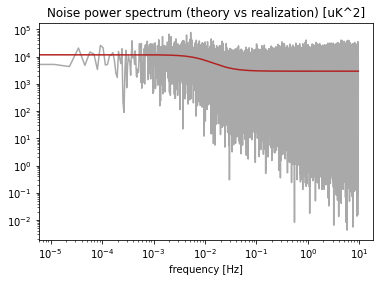

In [22]:
# Evaluating  and plotting the power spectrum
ps = np.abs(np.fft.fft(noise_TOD[0,:]))**2 / nsamp
time_step = 1. / f_samp
freqs = np.fft.fftfreq(noise_TOD[0,:].size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick')
plt.title('Noise power spectrum (theory vs realization) [uK^2]')
plt.xlabel('frequency [Hz]')
plt.show()

Averaging 300 realizations of the noise, the power spectrum recovers the theoretical one.

In [32]:
ps = np.zeros(nsamp)
nps = int(300)

gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)

for i in range(nps):
    noise = np.zeros(nsamp)
    for chunk in range(nchunk):
        inp = np.random.normal(0.,1.,(nsamp_chunk,))
        #
        noise[chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = gen.filterGaussian(inp)
    ps += np.abs(np.fft.fft(noise))**2 / nsamp

ps = ps/nps

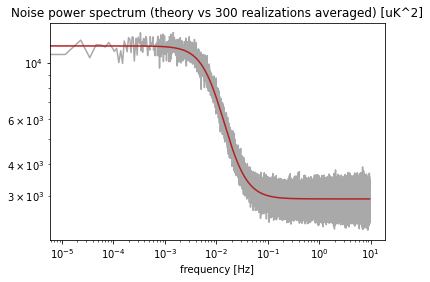

In [33]:
# Plotting the power spectrum
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick')
plt.title('Noise power spectrum (theory vs 300 realizations averaged) [uK^2]')
plt.xlabel('frequency [Hz]')
plt.show()

Here they are the TOD:

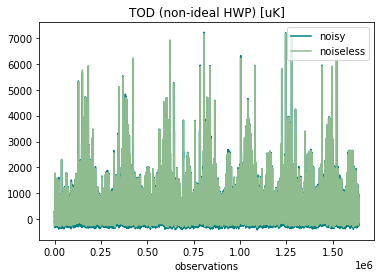

In [25]:
plt.plot(noiseless_TOD_nonidealities[0,:]+noise_TOD[0,:],'teal',label='noisy')
plt.plot(noiseless_TOD_nonidealities[0,:],'darkseagreen',label='noiseless')
plt.legend(loc=1)
plt.title('TOD (non-ideal HWP) [uK]')
plt.xlabel('observations')
plt.show()

The noiseless TOD seem to be "periodic". This actually makes sense, since the "period" correspond to a precession period.

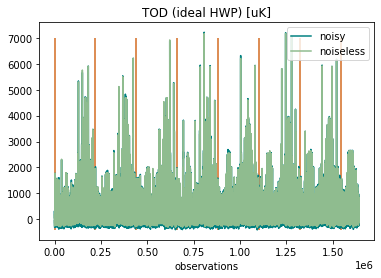

In [34]:
prec_idx = int(3.2058 * 60 * 60 * 19.1)

plt.plot(noiseless_TOD_nonidealities[0,:]+noise_TOD[0,:],'teal',label='noisy')
plt.plot(noiseless_TOD_nonidealities[0,:],'darkseagreen',label='noiseless')
plt.vlines(0*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(1*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(2*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(3*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(4*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(5*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(6*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.vlines(7*prec_idx, -400, 7000, colors='chocolate', linestyles='solid', label='')
plt.legend(loc=1)
plt.title('TOD (ideal HWP) [uK]')
plt.xlabel('observations')
plt.show()

### Non-idealities effects

Also, we can see how the presence of the HWP non-idealities affects the TOD.

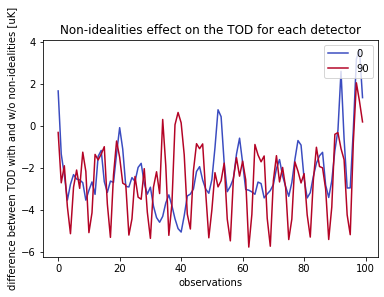

In [27]:
n = ndet
color = plt.cm.coolwarm(np.linspace(0,1,n))
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

plt.plot(noiseless_TOD_nonidealities[0][:100]-noiseless_TOD[0][:100],label='0')
plt.plot(noiseless_TOD_nonidealities[1][:100]-noiseless_TOD[1][:100],label='90')
#plt.plot(noiseless_TOD_nonidealities[2][:100]-noiseless_TOD[2][:100],label='0')
#plt.plot(noiseless_TOD_nonidealities[3][:100]-noiseless_TOD[3][:100],label='90')
plt.title('Non-idealities effect on the TOD for each detector')
plt.legend(loc=1)
plt.xlabel('observations')
plt.ylabel('difference between TOD with and w/o non-idealities [uK]')
plt.show()

TB pairs are affected identically by the non-idealities. Does it make sense?

### Coverage maps
As a countercheck, let us produce the coverage maps.

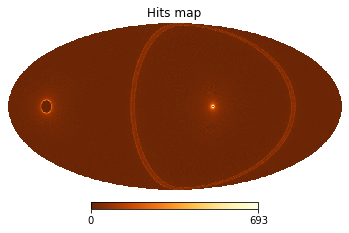

In [45]:
hp.mollview(proj_nonidealities[0],title='Hits map', hold=True, cmap=cmap_lighter)
plt.show()

#hp.mollview(proj_hwp[0]-proj[0],title='Difference', hold=True, cmap=cmap_magma)
#plt.show()

### Noisy TOD (with and without HWP)
 - The coverage maps look good;
 - The noise looks good;
 - The HWP behaves well (see <code>demo.ipynb</code>).

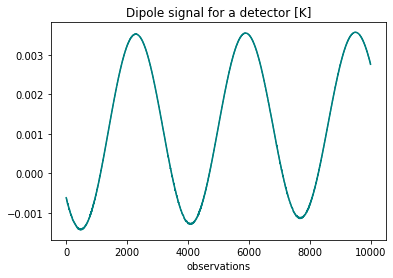

In [46]:
plt.plot(dipole_TOD[0][:10000], color='teal')
plt.title('Dipole signal for a detector [K]')
plt.xlabel('observations')
#plt.ylabel('dipole [K]')
plt.show()

## Steps further
- Include frequency-dependence of HWP non-idealities
- More realistic beam shapes
- Adapt this for production purposes (what does the collaboration need? which format?)